## Creating Custom Networks
In this notebook you have to create a custom network whose architecture has been given, and use the dataset you created earlier to train and test it.

In [ ]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import glob
import torchvision
import PIL.Image
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

All hyper parameters go in the next block

In [ ]:
batch_size = 100
num_epochs = 5
learning_rate = 0.01

### Create Custom Dataset and Loader
This is the same as part 1. Simply use the same code to create the dataset.

In [ ]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        if(train):
            dir = root_dir + '/train'
        else :
            dir = root_dir + '/test'
        self.transform = transform
        self.img = []
        self.label = []
        for file_path in glob.glob(dir+'/*/*.png'):
            image = PIL.Image.open(file_path)
            self.img.append(image.convert('RGB'))
            self.label.append(ord(file_path.split('/')[-2]) - ord('A')) #ord makes A,B,C.. to 0,1,2,.. respectively
            
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.img)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        if self.transform is None:
            return (self.img[idx],self.label[idx])
        else:
            img_transformed = self.transform(self.img[idx])
            return (img_transformed,self.label[idx])
    
composed_transform = transforms.Compose([transforms.Scale((32,32)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='../notMNIST_small', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='../notMNIST_small', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Creating a Custom Network
It's time to create a new custom network. This network is based on Resnet (indeed it is a resnet since it uses skip connections). The architecture of the network is provided in the diagram. It specifies the layer names, layer types as well as their parameters.
<img src="architecture.png" width=100>
[Full size image](architecture.html)

In [ ]:
class CustomResnet(nn.Module): # Extend PyTorch's Module class
    def __init__(self, num_classes = 10):
        super(CustomResnet, self).__init__() # Must call super __init__()
       
        self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.lyr1conv1 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias =True)
        self.lyr1bn1 = nn.BatchNorm2d(64)
        self.lyr1relu1 = nn.ReLU(inplace=True)
        
        self.lyr1conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias = True)
        self.lyr1bn2 = nn.BatchNorm2d(64)
        self.lyr1relu2 = nn.ReLU(inplace=True)
        
        self.lyr2conv1 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias = True)
        self.lyr2bn1 = nn.BatchNorm2d(64)
        self.lyr2relu1 = nn.ReLU(inplace=True)
        
        self.lyr2conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias =True)
        self.lyr2bn2 = nn.BatchNorm2d(64)
        self.lyr2relu2 = nn.ReLU(inplace=True)
        
        
        self.fc = nn.Linear(4096,num_classes)
        
        # Define the layers of the network here
        # There should be 17 total layers as evident from the diagram
        # The parameters and names for the layers are provided in the diagram
        # The variable names have to be the same as the ones in the diagram
        # Otherwise, the weights will not load
        
    def forward(self, x):
        # Here you have to define the forward pass
        # Make sure you take care of the skip connections
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
#         print (x.size())
        
        temp = self.lyr1conv1(x)
        temp = self.lyr1bn1(temp)
        temp = self.lyr1relu1(temp)
        temp = self.lyr1conv2(temp)
        temp = self.lyr1bn2(temp)
       
       
        x = self.lyr1relu2(temp + x) 
       
        temp = self.lyr2conv1(x)
        temp = self.lyr2bn1(temp)
        temp = self.lyr2relu1(temp)
        temp = self.lyr2conv2(temp)
        temp = self.lyr2bn2(temp)
       
        x = self.lyr2relu2(temp + x)
    
        x= self.fc(x.view(-1,4096))
        
        return x

#### Finetune on pre-trained CIFAR-100 weights
We shall now finetune our model using pretrained CIFAR-100 weights.

In [ ]:
model = CustomResnet(num_classes = 100) # 100 classes since CIFAR-100 has 100 classes

# Load CIFAR-100 weights. (Download them from assignment page)
# If network was properly implemented, weights should load without any problems
model.load_state_dict(torch.load('../CIFAR-100_weights')) # Supply the path to the weight file

##### Optional
As a sanity check you may load the CIFAR-100 test dataset and test the above model. You should get an accuracy of ~41%. This part is optional and is meant for your convenience.

In [ ]:
# Block for optionally running the model on CIFAR-100 test set

Let's finetune the model.

Epoch [1/5], Step [100/168], Loss: 0.2088
Epoch [2/5], Step [100/168], Loss: 0.1561
Epoch [3/5], Step [100/168], Loss: 0.0783
Epoch [4/5], Step [100/168], Loss: 0.0435
Epoch [5/5], Step [100/168], Loss: 0.0984


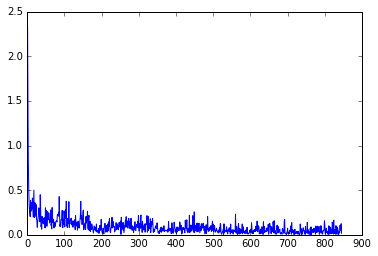

CPU times: user 31.5 s, sys: 6.53 s, total: 38 s
Wall time: 37.9 s


In [10]:
# Change last layer to output 10 classes since our dataset has 10 classes
# model.fc = nn.Linear(100, 10)# Complete this statement. It is similar to the resnet18 case
model.fc = nn.Linear(model.fc.in_features, 10)


# Add code for using CUDA here if it is available
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    model.cuda()

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()# Define cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)# Use Adam optimizer, use learning_rate hyper parameter

def train():
    # Code for training the model
    # Make sure to output a matplotlib graph of training losses
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.data[0])
            if (i+1) % batch_size == 0:       
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()
%time train()

Test the finetuned model

In [11]:
def test():
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the ' + str(total) +' test images: %d %%' % (100 * correct / total))
    
%time test()

Accuracy of the network on the 1870 test images: 91 %
CPU times: user 332 ms, sys: 92 ms, total: 424 ms
Wall time: 421 ms


#### Training from scratch
Now we shall try training the model from scratch and observe the differences.

Epoch [1/5], Step [100/168], Loss: 0.3058
Epoch [2/5], Step [100/168], Loss: 0.2228
Epoch [3/5], Step [100/168], Loss: 0.1915
Epoch [4/5], Step [100/168], Loss: 0.1774
Epoch [5/5], Step [100/168], Loss: 0.1295


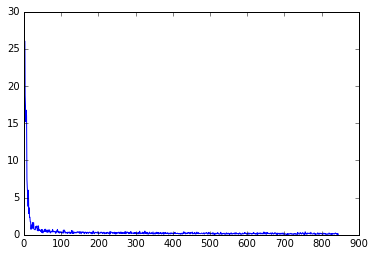

CPU times: user 32.1 s, sys: 6.7 s, total: 38.8 s
Wall time: 38.6 s
Accuracy of the network on the 1870 test images: 91 %
CPU times: user 376 ms, sys: 172 ms, total: 548 ms
Wall time: 411 ms


In [12]:
# Reinstantiate the model and optimizer
model = CustomResnet(num_classes = 10)
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # Use Adam optimizer, use learning_rate hyper parameter

# Train
%time train()

# Test
%time test()

This is the end of Assignment 1